# Profitable App Profiles for the Apple App Store and Google Play Store
2019-08-29

last updated 2019-09-04

New entrants into the mobile application space have a daunting task ahead of them with regards to standing out and being profitable in an extremely crowded marketplace [1][1]. Here I analyze data on apps in the Apple and Google app stores to identify types of apps likely to attract larger user bases, with the specific goal of identifying types of *free* apps that are likely to attract the most users on the Apple App Store and Google Play Store, with number of users as a proxy for potential ad revenue.

Data sources: 

https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps/downloads/app-store-apple-data-set-10k-apps.zip/7

https://www.kaggle.com/lava18/google-play-store-apps/downloads/google-play-store-apps.zip/6


[1]: https://www.statista.com/statistics/276623/number-of-apps-available-in-leading-app-stores/ "app totals"

In [32]:
# import datasets - downloaded from Kaggle
from csv import reader
androidfile = open('google-play-store-apps/googleplaystore.csv', encoding='utf8')
androidread = list(reader(androidfile))
android = androidread[1:]
androidheader = androidread[0]

applefile = open('app-store-apple-data-set-10k-apps/AppleStore.csv', encoding='utf8')
appleread = list(reader(applefile))
apple = appleread[1:]
appleheader = appleread[0]

# explore_data() function to easily read in and explore datasets
def explore_data(dataset, start, end, rows_and_columns=False):
    dataset_slice = dataset[start:end]
    for row in dataset_slice:
        print(row)
        print('\n') # adds a new (empty) line after each row for easier viewing
        
    if rows_and_columns:
        print('Number of rows:', len(dataset))
        print('Number of columns:', len(dataset[0]))
        
explore_data(android, start=0, end=5, rows_and_columns=True)
explore_data(apple, 0, 5, True)

['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', '4.1', '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']


['Coloring book moana', 'ART_AND_DESIGN', '3.9', '967', '14M', '500,000+', 'Free', '0', 'Everyone', 'Art & Design;Pretend Play', 'January 15, 2018', '2.0.0', '4.0.3 and up']


['U Launcher Lite – FREE Live Cool Themes, Hide Apps', 'ART_AND_DESIGN', '4.7', '87510', '8.7M', '5,000,000+', 'Free', '0', 'Everyone', 'Art & Design', 'August 1, 2018', '1.2.4', '4.0.3 and up']


['Sketch - Draw & Paint', 'ART_AND_DESIGN', '4.5', '215644', '25M', '50,000,000+', 'Free', '0', 'Teen', 'Art & Design', 'June 8, 2018', 'Varies with device', '4.2 and up']


['Pixel Draw - Number Art Coloring Book', 'ART_AND_DESIGN', '4.3', '967', '2.8M', '100,000+', 'Free', '0', 'Everyone', 'Art & Design;Creativity', 'June 20, 2018', '1.1', '4.4 and up']


Number of rows: 10841
Number of columns: 13
['1', '281656475', 'PAC-MAN Premium

## Relevant columns

Based on a quick glance of the datasets, we can choose some more relevant columns for our given task. 

For Android apps: Category, Rating (maybe), Reviews, Installs, Type or Price, Genres. We only want to consider free apps (Type=='Free' or Price==0). Category and Genres are related, with Category looking like the first Genre (an app can have multiple genres, but only gets one Category). We'll keep it simple for now and use Category.

For Apple apps: currency (keep only USD apps), price, rating_count_tot, rating_count_ver (total ratings for current version only), prime_genre

## Data cleaning

We need to clean the data. Let Dataquest walk us through for now. DQ notes the Google Play data has a [discussion](https://www.kaggle.com/lava18/google-play-store-apps/discussion/66015) identifying an error. We can inspect and remove the offending row. Browsing the Kaggle discussion for the Apple data reveals no identified errors (doesn't mean there aren't any!). There are also duplicate entries that should be removed.

In [38]:
# remove entry 10472 (not including header)
print(android[10472])
#del android[10472] # only run once! Ideally would delete using a unique feature, e.g. app name

['osmino Wi-Fi: free WiFi', 'TOOLS', '4.2', '134203', '4.1M', '10,000,000+', 'Free', '0', 'Everyone', 'Tools', 'August 7, 2018', '6.06.14', '4.4 and up']


In [104]:
### Remove duplicate entries
duplicate_apps = []
unique_apps = []

for app in android:
    name = app[0]
    if name in unique_apps:
        duplicate_apps.append(name)
    else:
        unique_apps.append(name)
        
print('Number of duplicate apps:', len(duplicate_apps))
print('\n')
print('Examples of duplicate apps:', duplicate_apps[:15])


apple_duplicate_apps = []
apple_unique_apps = []

for app in apple:
    name = app[2]
    if name in apple_unique_apps:
        apple_duplicate_apps.append(name)
    else:
        apple_unique_apps.append(name)
        
print('Number of duplicate apps:', len(apple_duplicate_apps))
print('\n')
print('Examples of duplicate apps:', apple_duplicate_apps[:15])



Number of duplicate apps: 1181


Examples of duplicate apps: ['Quick PDF Scanner + OCR FREE', 'Box', 'Google My Business', 'ZOOM Cloud Meetings', 'join.me - Simple Meetings', 'Box', 'Zenefits', 'Google Ads', 'Google My Business', 'Slack', 'FreshBooks Classic', 'Insightly CRM', 'QuickBooks Accounting: Invoicing & Expenses', 'HipChat - Chat Built for Teams', 'Xero Accounting Software']
Number of duplicate apps: 2


Examples of duplicate apps: ['VR Roller Coaster', 'Mannequin Challenge']


The Android data has 1181 duplicate entries. We could keep one at random, or we could keep the most recent entry, using the entry with the highest number of reviews as the most recent. (We can reasonably expect number of reviews to increase with time, so more reviews = more recent entry)

In [52]:
# to remove duplicates, create a dictionary, where key == unique app name and value == highest number of reviews of that app
# use 'not in' operator to check for membership in a dictionary

# e.g. print('z' not in ['a', 'b', 'c'])

reviews_max = {} # empty dictionary
for app in android:
    name = app[0]
    n_reviews = float(app[3]) # number of reviews is the 3rd index (4th column) in the table
    if name in reviews_max and reviews_max[name] < n_reviews:
        reviews_max[name] = n_reviews
    elif name not in reviews_max:
        reviews_max[name] = n_reviews
        
print(len(reviews_max)) # should have 9659 entries

9659


Now actually remove duplicate rows, using reviews_max dictionary.
We have the highest number of reviews for a given app in the `reviews_max` dictionary. When this matches the
number of reviews in an entry in the full `android` app table, we will keep that row.
When the loop encounters another entry for the same app, it skips it because its name is already in the `already_added` list.
We need this `already_added` condition in case duplicate entries have the same number of reviews.

In [87]:

android_clean = [] # store the new cleaned dataset with all columns
already_added = [] # just store app names

for app in android:
    name = app[0]
    n_reviews = float(app[3])
    if n_reviews == reviews_max[name] and name not in already_added:
        android_clean.append(app) # appends the whole row
        already_added.append(name) # appends just the name to keep track of which apps have been added
        
print(len(android_clean))

explore_data(android_clean, 0, 5, True)

9659
['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', '4.1', '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']


['U Launcher Lite – FREE Live Cool Themes, Hide Apps', 'ART_AND_DESIGN', '4.7', '87510', '8.7M', '5,000,000+', 'Free', '0', 'Everyone', 'Art & Design', 'August 1, 2018', '1.2.4', '4.0.3 and up']


['Sketch - Draw & Paint', 'ART_AND_DESIGN', '4.5', '215644', '25M', '50,000,000+', 'Free', '0', 'Teen', 'Art & Design', 'June 8, 2018', 'Varies with device', '4.2 and up']


['Pixel Draw - Number Art Coloring Book', 'ART_AND_DESIGN', '4.3', '967', '2.8M', '100,000+', 'Free', '0', 'Everyone', 'Art & Design;Creativity', 'June 20, 2018', '1.1', '4.4 and up']


['Paper flowers instructions', 'ART_AND_DESIGN', '4.4', '167', '5.6M', '50,000+', 'Free', '0', 'Everyone', 'Art & Design', 'March 26, 2017', '1.0', '2.3 and up']


Number of rows: 9659
Number of columns: 13


In [105]:
# Repeat for Apple
apple_reviews_max = {} # empty dictionary
for app in apple:
    name = app[2] # app name is 2nd index in apple data
    n_reviews = float(app[6]) # number of reviews is the  6th index in the apple data
    if name in apple_reviews_max and apple_reviews_max[name] < n_reviews:
        apple_reviews_max[name] = n_reviews
    elif name not in apple_reviews_max:
        apple_reviews_max[name] = n_reviews
        
print(len(apple_reviews_max)) 

apple_clean = [] # store the new cleaned dataset with all columns
apple_already_added = [] # just store app names

for app in apple:
    name = app[2]
    n_reviews = float(app[6])
    if n_reviews == apple_reviews_max[name] and name not in apple_already_added:
        apple_clean.append(app) # appends the whole row
        apple_already_added.append(name) # appends just the name to keep track of which apps have been added
        
print(len(apple_clean))

explore_data(apple_clean, 0, 5, True)

7195
7195
['1', '281656475', 'PAC-MAN Premium', '100788224', 'USD', '3.99', '21292', '26', '4', '4.5', '6.3.5', '4+', 'Games', '38', '5', '10', '1']


['2', '281796108', 'Evernote - stay organized', '158578688', 'USD', '0', '161065', '26', '4', '3.5', '8.2.2', '4+', 'Productivity', '37', '5', '23', '1']


['3', '281940292', 'WeatherBug - Local Weather, Radar, Maps, Alerts', '100524032', 'USD', '0', '188583', '2822', '3.5', '4.5', '5.0.0', '4+', 'Weather', '37', '5', '3', '1']


['4', '282614216', 'eBay: Best App to Buy, Sell, Save! Online Shopping', '128512000', 'USD', '0', '262241', '649', '4', '4.5', '5.10.0', '12+', 'Shopping', '37', '5', '9', '1']


['5', '282935706', 'Bible', '92774400', 'USD', '0', '985920', '5320', '4.5', '5', '7.5.1', '4+', 'Reference', '37', '5', '45', '1']


Number of rows: 7195
Number of columns: 17


We have more filtering we'd like to do. We are only interested in apps oriented toward English speakers, so we can check that characters in app names are Western characters.



In [77]:
# function that returns False if any characters in a given string are not common English characters

def isenglish(string):
    for char in string:
        if ord(char) > 127:
           return False
    return True

# test it out
print(isenglish('Instagram'))
print(isenglish('爱奇艺PPS -《欢乐颂2》电视剧热播'))
print(isenglish('Docs To Go™ Free Office Suite'))
print(isenglish('Instachat 😜'))

True
False
False
False


Our `isenglish` function is a little rough - unfortunately it identifies names with emojis and other symbols as non-English. We can make it a bit more robust by only identifying app names with more than a few non-standard-English characters as non-English.

In [81]:
# keep count of the number of non-english characters and make conditional statements based on the count

def isenglish(string):
    nonengcount = 0
    for char in string:
        if ord(char) > 127:
           nonengcount += 1
    if nonengcount >= 3:
        return False
    return True

# test it out
print(isenglish('Instagram'))
print(isenglish('爱奇艺PPS -《欢乐颂2》电视剧热播'))
print(isenglish('Docs To Go™ Free Office Suite'))
print(isenglish('Instachat 😜'))

In [106]:
# filter out apps from both android and apple datasets:

android_clean2 = []
for app in android_clean:
    name = app[0]
    if isenglish(name) == True:
        android_clean2.append(app)

print(len(android), 'Android apps total')
print(len(android_clean), 'Android apps after filtering for duplicates')   
print(len(android_clean2), 'Android apps after filtering for English')
explore_data(android_clean2, 0, 5, False)
        

10840 Android apps total
9659 Android apps after filtering for duplicates
9597 Android apps after filtering for English
['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', '4.1', '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']


['U Launcher Lite – FREE Live Cool Themes, Hide Apps', 'ART_AND_DESIGN', '4.7', '87510', '8.7M', '5,000,000+', 'Free', '0', 'Everyone', 'Art & Design', 'August 1, 2018', '1.2.4', '4.0.3 and up']


['Sketch - Draw & Paint', 'ART_AND_DESIGN', '4.5', '215644', '25M', '50,000,000+', 'Free', '0', 'Teen', 'Art & Design', 'June 8, 2018', 'Varies with device', '4.2 and up']


['Pixel Draw - Number Art Coloring Book', 'ART_AND_DESIGN', '4.3', '967', '2.8M', '100,000+', 'Free', '0', 'Everyone', 'Art & Design;Creativity', 'June 20, 2018', '1.1', '4.4 and up']


['Paper flowers instructions', 'ART_AND_DESIGN', '4.4', '167', '5.6M', '50,000+', 'Free', '0', 'Everyone', 'Art & Design', 'March 26, 2

In [109]:
apple_clean2 = []
for app in apple_clean:
    name = app[2]
    if isenglish(name) == True:
        apple_clean2.append(app)
        
print(len(apple), 'Apple apps total')
print(len(apple_clean), 'Apple apps after filtering for duplicates')
print(len(apple_clean2), 'Apple apps after filtering for English')
explore_data(apple_clean2, 0, 5, True)
     

7197 Apple apps total
7195 Apple apps after filtering for duplicates
6153 Apple apps after filtering for English
['1', '281656475', 'PAC-MAN Premium', '100788224', 'USD', '3.99', '21292', '26', '4', '4.5', '6.3.5', '4+', 'Games', '38', '5', '10', '1']


['2', '281796108', 'Evernote - stay organized', '158578688', 'USD', '0', '161065', '26', '4', '3.5', '8.2.2', '4+', 'Productivity', '37', '5', '23', '1']


['3', '281940292', 'WeatherBug - Local Weather, Radar, Maps, Alerts', '100524032', 'USD', '0', '188583', '2822', '3.5', '4.5', '5.0.0', '4+', 'Weather', '37', '5', '3', '1']


['4', '282614216', 'eBay: Best App to Buy, Sell, Save! Online Shopping', '128512000', 'USD', '0', '262241', '649', '4', '4.5', '5.10.0', '12+', 'Shopping', '37', '5', '9', '1']


['5', '282935706', 'Bible', '92774400', 'USD', '0', '985920', '5320', '4.5', '5', '7.5.1', '4+', 'Reference', '37', '5', '45', '1']


Number of rows: 6153
Number of columns: 17


In [110]:
apple[0:5]
print(appleheader)
print(apple[:5], '\n')

['', 'id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']
[['1', '281656475', 'PAC-MAN Premium', '100788224', 'USD', '3.99', '21292', '26', '4', '4.5', '6.3.5', '4+', 'Games', '38', '5', '10', '1'], ['2', '281796108', 'Evernote - stay organized', '158578688', 'USD', '0', '161065', '26', '4', '3.5', '8.2.2', '4+', 'Productivity', '37', '5', '23', '1'], ['3', '281940292', 'WeatherBug - Local Weather, Radar, Maps, Alerts', '100524032', 'USD', '0', '188583', '2822', '3.5', '4.5', '5.0.0', '4+', 'Weather', '37', '5', '3', '1'], ['4', '282614216', 'eBay: Best App to Buy, Sell, Save! Online Shopping', '128512000', 'USD', '0', '262241', '649', '4', '4.5', '5.10.0', '12+', 'Shopping', '37', '5', '9', '1'], ['5', '282935706', 'Bible', '92774400', 'USD', '0', '985920', '5320', '4.5', '5', '7.5.1', '4+', 'Reference', '37', '5'

## Isolate free apps

In [123]:
# android
android_free = []
for app in android_clean2:
    if app[6] == 'Free':
        android_free.append(app)
        
print(len(android_clean2), 'filtered Android apps')
print(len(android_free), 'free filtered Android apps')
    

# apple
apple_free = []
for app in apple_clean2:
    if float(app[5]) == 0:
        apple_free.append(app)
        
print(len(apple_clean2), 'filtered Apple apps')
print(len(apple_free), 'free filtered Apple apps')
    

9597 filtered Android apps
8847 free filtered Android apps
6153 filtered Apple apps
3201 free filtered Apple apps


## Analyzing our filtered data
Now that we have filtered our datasets and isolated the free apps, we can come back to our main goal: identifying genres of apps that are the most popular to guide us in our choice of genre for developing our own app, in order to maximize ad revenue. With our filtered datasets, we can identify the columns we care about for addressing this and producing frequency tables from them.

In [128]:
# print the column names again

print(appleheader) # let's use prime_genre
print(androidheader) # let's use Category

# make function to generate a frequency table of apps by column (in this case, genre or category)
def freq_table(dataset, index): # dataset is a list of lists, index is an integer 
    table = {} # dictionary
    total = 0
    for row in dataset:
        total += 1 # counts all rows
        value = row[index]
        if value in table:
            table[value] += 1 # a category, e.g. Games, would become the key, and the count of apps in the Games category is the value for that key in the dictionary
        else:
            table[value] = 1
            
    table_percentages = {}
    for key in table:
        percentage = (table[key] / total) * 100
        table_percentages[key] = percentage
    return table_percentages
        


# we can sort our tables using built-in sorted() function, and some duct tape. Much easier ways to do this later...
def display_table(dataset, index):
    table = freq_table(dataset, index)
    table_display = []
    for key in table:
        key_val_as_tuple = (table[key], key)
        table_display.append(key_val_as_tuple)

    table_sorted = sorted(table_display, reverse = True)
    for entry in table_sorted:
        print(entry[1], ':', entry[0])
        


['', 'id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']
['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


In [132]:
display_table(apple_free, -5) # index for prime_genre is 12 or -5

Games : 58.23180256169947
Entertainment : 7.841299593876913
Photo & Video : 4.99843798812871
Education : 3.6863480162449234
Social Networking : 3.3114651671352706
Shopping : 2.592939706341768
Utilities : 2.4679787566385505
Sports : 2.1555763823805063
Music : 2.0618556701030926
Health & Fitness : 2.0306154326772883
Productivity : 1.7494532958450486
Lifestyle : 1.5620118712902218
News : 1.3433302093095907
Travel : 1.2496094970321776
Finance : 1.0934083099031553
Weather : 0.8747266479225243
Food & Drink : 0.8122461730709154
Reference : 0.5310840362386754
Business : 0.5310840362386754
Book : 0.37488284910965325
Navigation : 0.18744142455482662
Medical : 0.18744142455482662
Catalogs : 0.12496094970321774


In English apps in the Apple App Store, 58% are games. Gaming/entertainment apps are the most common, while more practical apps are less common. 

This doesn't necessarily mean gaming and entertainment apps are the best business opportunity though - we want to examine how much they're used. It's possible that games are just easier to make and publish, but may not be the best proxy for user engagement for ad revenue.

The pattern differs a bit for Android, with a more even distribution across categories, but still weighted toward entertainment (family/games).

In [133]:
display_table(android_free, 1)

FAMILY : 18.932971628800725
GAME : 9.698202780603594
TOOLS : 8.45484344975698
BUSINESS : 4.600429524132474
PRODUCTIVITY : 3.8996269922007465
LIFESTYLE : 3.888323725556686
FINANCE : 3.7074714592517237
MEDICAL : 3.537922459590822
SPORTS : 3.39097999321804
PERSONALIZATION : 3.3231603933536795
COMMUNICATION : 3.2327342602011986
HEALTH_AND_FITNESS : 3.0857917938284163
PHOTOGRAPHY : 2.950152594099695
NEWS_AND_MAGAZINES : 2.803210127726913
SOCIAL : 2.6675709279981916
TRAVEL_AND_LOCAL : 2.3397761953204474
SHOPPING : 2.2493500621679665
BOOKS_AND_REFERENCE : 2.136317395727365
DATING : 1.8650389962699219
VIDEO_PLAYERS : 1.797219396405561
MAPS_AND_NAVIGATION : 1.3903017972193965
FOOD_AND_DRINK : 1.2433593308466147
EDUCATION : 1.1642364643381937
ENTERTAINMENT : 0.9607776647451114
LIBRARIES_AND_DEMO : 0.938171131456991
AUTO_AND_VEHICLES : 0.9268678648129309
HOUSE_AND_HOME : 0.8025319317282694
WEATHER : 0.7912286650842093
EVENTS : 0.7121057985757884
PARENTING : 0.6555894653554878
ART_AND_DESIGN : 0.6

What else can we analyze as proxies of popularity or user engagement? We can look at the total number of downloads or number of ratings.

We can use a nested loop to generate frequency tables of downloads by category.

In [194]:
import statistics # enables median()

prime_freqtable = freq_table(apple_free, -5)

#print(prime_freqtable)
lol = [] # create empty list to store the genre and average number of ratings
for genre in prime_freqtable:
    appratings = []
    total = 0 # store total number of user ratings
    len_genre = 0 # store number of apps in each genre
    for app in apple_free:
        genre_app = app[-5]
        if genre_app == genre: # if the genre is the same, save the total number of reviews to "total"
            total += float(app[6])
            appratings.append(float(app[6])) # create a list of all the rating totals for a given genre of apps
            len_genre += 1
    medianrating = statistics.median(appratings) # generates the median from the list of rating totals
    avgratings = total / len_genre
    lol.append([genre, avgratings, medianrating]) # by storing this as a list of lists we can sort the output
    #print([genre, avgratings])
print('Sorted by mean:', sorted(lol, key=lambda x: float(x[1]), reverse=True), '\n') # can use a lambda function for the key to sort by the second element in each row (here, by the number of ratings)
print('Sorted by median:', sorted(lol, key=lambda x: float(x[2]), reverse=True), '\n') # can use a lambda function for the key to sort by the second element in each row (here, by the number of ratings)


Sorted by mean: [['Navigation', 86090.33333333333, 8196.5], ['Reference', 79350.4705882353, 8535.0], ['Social Networking', 71548.34905660378, 4199.0], ['Music', 57326.530303030304, 3850.0], ['Weather', 52279.892857142855, 289.0], ['Book', 46384.916666666664, 665.0], ['Food & Drink', 33333.92307692308, 1490.5], ['Finance', 32367.02857142857, 2207.0], ['Photo & Video', 28441.54375, 2206.0], ['Travel', 28243.8, 798.5], ['Shopping', 27230.734939759037, 6408.0], ['Health & Fitness', 23298.015384615384, 2459.0], ['Sports', 23008.898550724636, 1628.0], ['Games', 22910.83100858369, 919.0], ['News', 21248.023255813954, 373.0], ['Productivity', 21028.410714285714, 8737.5], ['Utilities', 19156.493670886077, 1341.0], ['Lifestyle', 16815.48, 1183.0], ['Entertainment', 14195.358565737051, 1205.0], ['Business', 7491.117647058823, 1150.0], ['Education', 7003.983050847458, 606.5], ['Catalogs', 4004.0, 1229.0], ['Medical', 612.0, 566.5]] 

Sorted by median: [['Productivity', 21028.410714285714, 8737.5],

For free English Apple Store apps, Navigation apps have the highest average number of reviews. Average is a horrible metric here for determining average downloads/engagement/ratings - this is almost certainly skewed by Google Maps and Waze, with very few other competitors (meaning navigation apps are dominated by a few big players). Meanwhile, games have tons of newer entrants that will bring the average way down. 

If we sort by mean, we find Navigation, Reference, and Social Networking make up the top 3 most reviewed app categories.

If we sort by median, we find Productivity, Reference, and Navigation make up the top 3 most reviewed app categories. Medians differ greatly from the means, implying highly skewed distributions (likely bimodal or multimodal) - median should give us a slightly better idea of how a "typical" app in a given genre performs. For planning a new app, even better would be to look at the histogram of review counts and remove the highest reviewed apps from the bimodal distribution and take the median in the absence of those outliers.


Now for Android:

In [200]:
import statistics # enables statistics.median()

android_freqtable = freq_table(android_free, 1)

#print(prime_freqtable)
lol = [] # create empty list to store the genre and average number of ratings
for genre in android_freqtable:
    appratings = []
    total = 0 # store total number of user ratings
    len_genre = 0 # store number of apps in each genre
    for app in android_free:
        genre_app = app[1]
        if genre_app == genre: # if the genre is the same, save the total number of reviews to "total"
            total += float(app[3])
            appratings.append(float(app[3])) # create a list of all the rating totals for a given genre of apps
            len_genre += 1
    medianrating = statistics.median(appratings) # generates the median from the list of rating totals
    avgratings = total / len_genre
    lol.append([genre, avgratings, medianrating]) # by storing this as a list of lists we can sort the output
    #print([genre, avgratings])
print('Sorted by mean:', sorted(lol, key=lambda x: float(x[1]), reverse=True), '\n') # can use a lambda function for the key to sort by the second element in each row (here, by the number of ratings)
print('Sorted by median:', sorted(lol, key=lambda x: float(x[2]), reverse=True), '\n') # can use a lambda function for the key to sort by the second element in each row (here, by the number of ratings)


Sorted by mean: [['COMMUNICATION', 999089.6118881119, 6527.5], ['SOCIAL', 965830.9872881356, 3884.0], ['GAME', 684290.0629370629, 35371.5], ['VIDEO_PLAYERS', 425350.08176100627, 5555.0], ['PHOTOGRAPHY', 404081.3754789272, 31985.0], ['TOOLS', 306550.3034759358, 659.0], ['ENTERTAINMENT', 301752.24705882353, 35279.0], ['SHOPPING', 223887.34673366835, 13085.0], ['PERSONALIZATION', 181122.31632653062, 652.0], ['WEATHER', 173679.5285714286, 11403.5], ['PRODUCTIVITY', 160634.5420289855, 2131.0], ['MAPS_AND_NAVIGATION', 143611.27642276423, 1688.0], ['TRAVEL_AND_LOCAL', 129484.42512077295, 2277.0], ['SPORTS', 117317.25666666667, 1942.5], ['FAMILY', 113210.54626865672, 879.0], ['NEWS_AND_MAGAZINES', 93088.03225806452, 656.5], ['BOOKS_AND_REFERENCE', 88460.62962962964, 314.0], ['HEALTH_AND_FITNESS', 78094.9706959707, 3908.0], ['FOOD_AND_DRINK', 57478.79090909091, 3779.0], ['EDUCATION', 56293.09708737864, 13612.0], ['COMICS', 43371.57407407407, 1844.5], ['FINANCE', 38535.8993902439, 467.5], ['LIFE

For free English Android apps, the top 3 app categories by mean number of reviews are Communication, Social, and Game.

The top 3 app categories by median are: Game, Entertainment, and Photography.

Again, we see very high differences between the mean and median numbers, so the means are being skewed by extreme outliers.

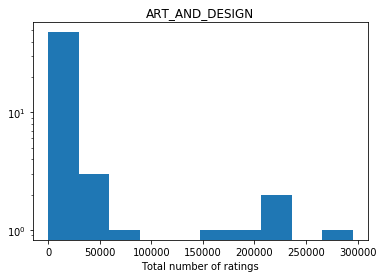

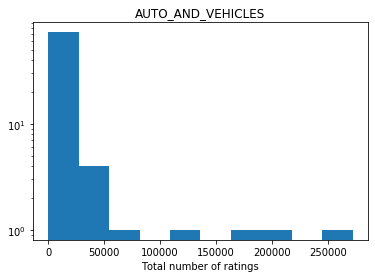

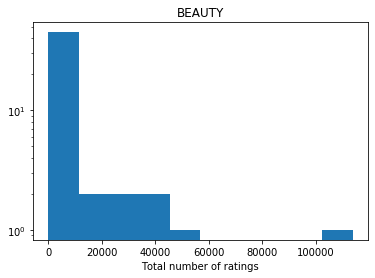

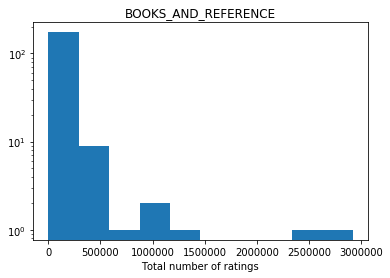

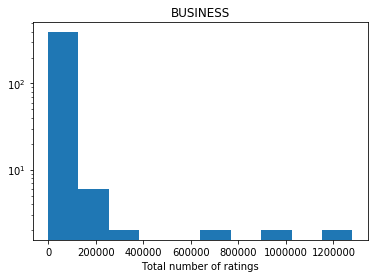

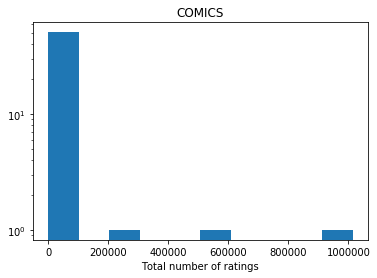

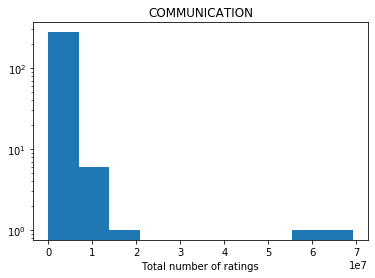

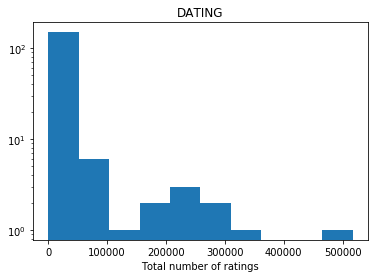

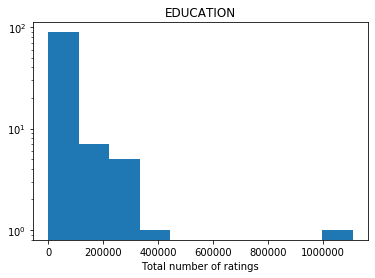

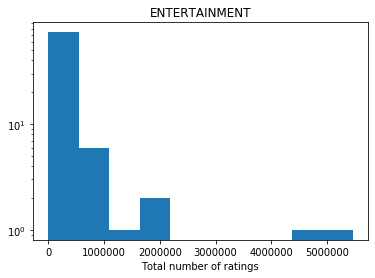

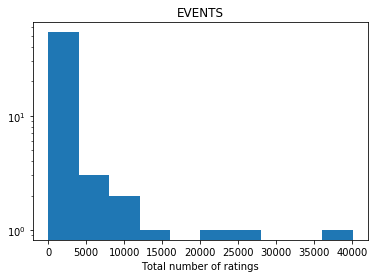

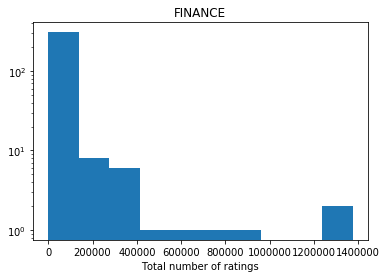

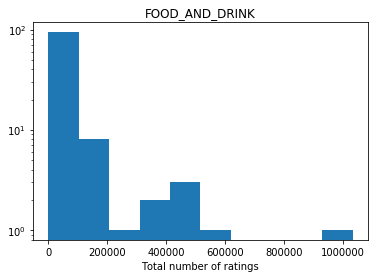

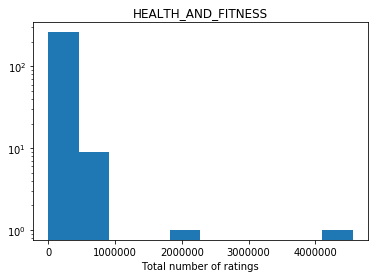

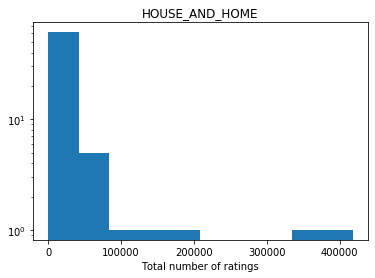

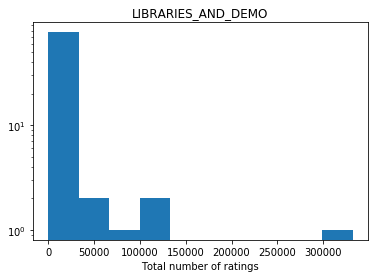

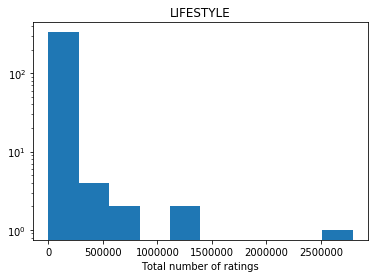

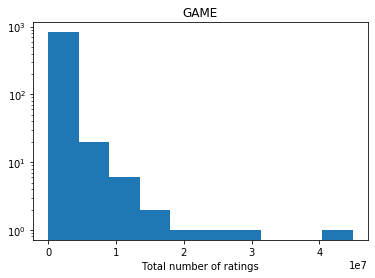

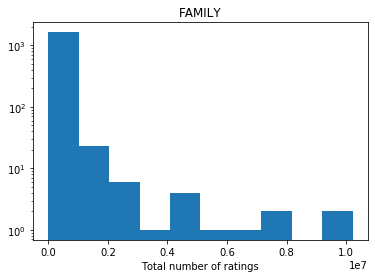

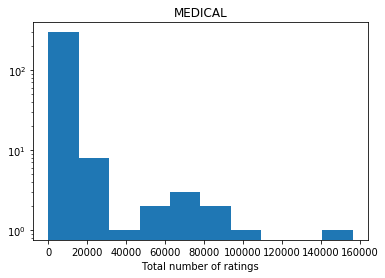

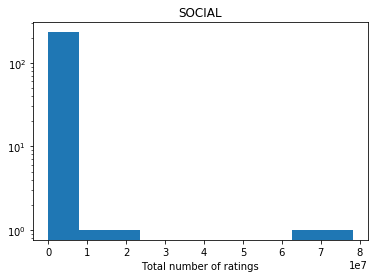

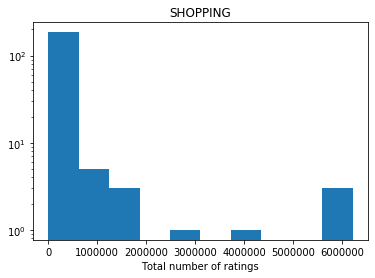

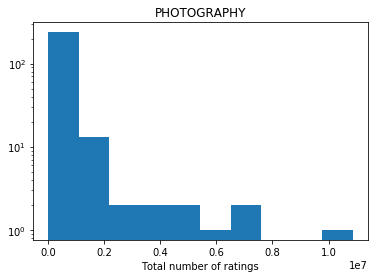

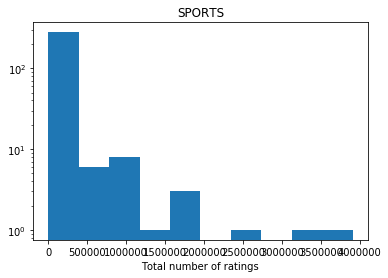

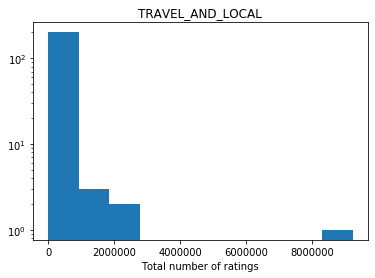

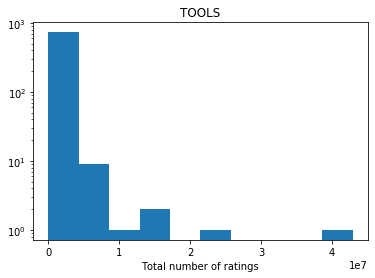

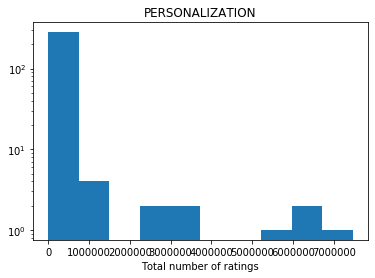

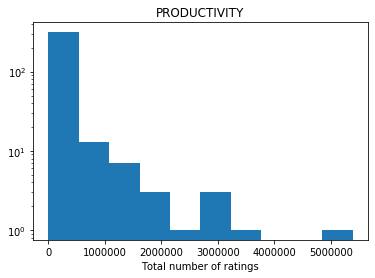

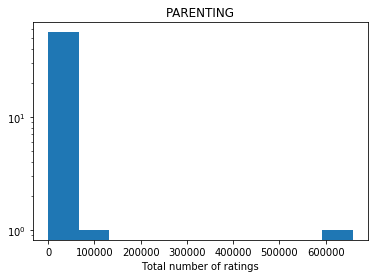

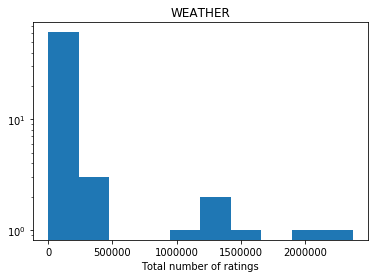

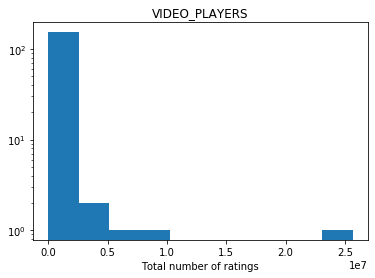

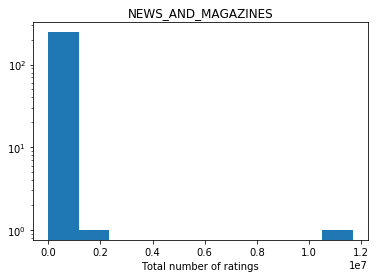

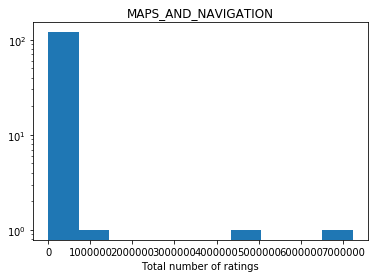

Sorted by mean: [['COMMUNICATION', 999089.6118881119, 6527.5], ['SOCIAL', 965830.9872881356, 3884.0], ['GAME', 684290.0629370629, 35371.5], ['VIDEO_PLAYERS', 425350.08176100627, 5555.0], ['PHOTOGRAPHY', 404081.3754789272, 31985.0], ['TOOLS', 306550.3034759358, 659.0], ['ENTERTAINMENT', 301752.24705882353, 35279.0], ['SHOPPING', 223887.34673366835, 13085.0], ['PERSONALIZATION', 181122.31632653062, 652.0], ['WEATHER', 173679.5285714286, 11403.5], ['PRODUCTIVITY', 160634.5420289855, 2131.0], ['MAPS_AND_NAVIGATION', 143611.27642276423, 1688.0], ['TRAVEL_AND_LOCAL', 129484.42512077295, 2277.0], ['SPORTS', 117317.25666666667, 1942.5], ['FAMILY', 113210.54626865672, 879.0], ['NEWS_AND_MAGAZINES', 93088.03225806452, 656.5], ['BOOKS_AND_REFERENCE', 88460.62962962964, 314.0], ['HEALTH_AND_FITNESS', 78094.9706959707, 3908.0], ['FOOD_AND_DRINK', 57478.79090909091, 3779.0], ['EDUCATION', 56293.09708737864, 13612.0], ['COMICS', 43371.57407407407, 1844.5], ['FINANCE', 38535.8993902439, 467.5], ['LIFE

In [227]:
# show some histograms

import numpy as np
import matplotlib.pyplot as plt
import statistics # enables statistics.median()

android_freqtable = freq_table(android_free, 1)

#print(prime_freqtable)
lol = [] # create empty list to store the genre and average number of ratings
for genre in android_freqtable:
    appratings = []
    total = 0 # store total number of user ratings
    len_genre = 0 # store number of apps in each genre
    for app in android_free:
        genre_app = app[1]
        if genre_app == genre: # if the genre is the same, save the total number of reviews to "total"
            total += float(app[3])
            appratings.append(float(app[3])) # create a list of all the rating totals for a given genre of apps
            len_genre += 1
    medianrating = statistics.median(appratings) # generates the median from the list of rating totals
    plt.hist(appratings)
    plt.xlabel('Total number of ratings')
    plt.title(genre)
    plt.yscale('log', nonposy='clip')
    plt.show() # shows a graph for each iteration of the loop
    avgratings = total / len_genre
    lol.append([genre, avgratings, medianrating]) # by storing this as a list of lists we can sort the output
    #print([genre, avgratings])
print('Sorted by mean:', sorted(lol, key=lambda x: float(x[1]), reverse=True), '\n') # can use a lambda function for the key to sort by the second element in each row (here, by the number of ratings)
print('Sorted by median:', sorted(lol, key=lambda x: float(x[2]), reverse=True), '\n') # can use a lambda function for the key to sort by the second element in each row (here, by the number of ratings)


In [204]:
# scrap

print(sorted(apple_free, key=lambda x: float(x[6]), reverse=True)[:20], '\n') # print the first 10 apps, sorted by number of reviews
#
print(sorted(android_free, key=lambda x: float(x[3]), reverse=True)[:20], '\n') # print the first 10 apps, sorted by number of reviews


[['17', '284882215', 'Facebook', '389879808', 'USD', '0', '2974676', '212', '3.5', '3.5', '95.0', '4+', 'Social Networking', '37', '1', '29', '1'], ['591', '389801252', 'Instagram', '113954816', 'USD', '0', '2161558', '1289', '4.5', '4', '10.23', '12+', 'Photo & Video', '37', '0', '29', '1'], ['1561', '529479190', 'Clash of Clans', '116476928', 'USD', '0', '2130805', '579', '4.5', '4.5', '9.24.12', '9+', 'Games', '38', '5', '18', '1'], ['810', '420009108', 'Temple Run', '65921024', 'USD', '0', '1724546', '3842', '4.5', '4', '1.6.2', '9+', 'Games', '40', '5', '1', '1'], ['8', '284035177', 'Pandora - Music & Radio', '130242560', 'USD', '0', '1126879', '3594', '4', '4.5', '8.4.1', '12+', 'Music', '37', '4', '1', '1'], ['863', '429047995', 'Pinterest', '74778624', 'USD', '0', '1061624', '1814', '4.5', '4', '6.26', '12+', 'Social Networking', '37', '5', '27', '1'], ['5', '282935706', 'Bible', '92774400', 'USD', '0', '985920', '5320', '4.5', '5', '7.5.1', '4+', 'Reference', '37', '5', '45', 

## Apps by number of installs (Android)

The Android data also provides number of installs, but only presents them as broad bin sizes (e.g. 1000+, 100,000+, 1M+). This might not be as useful as number of ratings, but we can try it out. Because the strings in these columns have the plus sign, we need to remove those before we can convert the numbers to floats. This will be inherently inaccurate because the values provided are only a floor for number of installs, but the exercise is good practice.



In [222]:
categories_android = freq_table(android_free, 1)

for category in categories_android:
    total = 0
    len_category = 0
    for app in android_free:
        category_app = app[1]
        if category_app == category:            
            n_installs = app[5]
            n_installs = n_installs.replace(',', '')
            n_installs = n_installs.replace('+', '')
            total += float(n_installs)
            len_category += 1
    avg_n_installs = total / len_category
    print(category, ':', avg_n_installs)

# again highly skewed, median would be better/we should remove outliers, but we already did that for the more precise number of ratings data


ART_AND_DESIGN : 1986335.0877192982
AUTO_AND_VEHICLES : 647317.8170731707
BEAUTY : 513151.88679245283
BOOKS_AND_REFERENCE : 8814199.78835979
BUSINESS : 1712290.1474201474
COMICS : 832613.8888888889
COMMUNICATION : 38590581.08741259
DATING : 854028.8303030303
EDUCATION : 1833495.145631068
ENTERTAINMENT : 11640705.88235294
EVENTS : 253542.22222222222
FINANCE : 1387692.475609756
FOOD_AND_DRINK : 1924897.7363636363
HEALTH_AND_FITNESS : 4188821.9853479853
HOUSE_AND_HOME : 1360598.042253521
LIBRARIES_AND_DEMO : 638503.734939759
LIFESTYLE : 1446158.2238372094
GAME : 15544014.51048951
FAMILY : 3697848.1731343283
MEDICAL : 120550.61980830671
SOCIAL : 23253652.127118643
SHOPPING : 7036877.311557789
PHOTOGRAPHY : 17840110.40229885
SPORTS : 3650602.276666667
TRAVEL_AND_LOCAL : 13984077.710144928
TOOLS : 10830251.970588235
PERSONALIZATION : 5201482.6122448975
PRODUCTIVITY : 16787331.344927534
PARENTING : 542603.6206896552
WEATHER : 5145550.285714285
VIDEO_PLAYERS : 24727872.452830188
NEWS_AND_MAGAZ

In [224]:
# get a sense of the skew

for app in android_free:
    if app[1] == 'COMMUNICATION' and (app[5] == '1,000,000,000+'
                                      or app[5] == '500,000,000+'
                                      or app[5] == '100,000,000+'):
        print(app[0], ':', app[5])



WhatsApp Messenger : 1,000,000,000+
imo beta free calls and text : 100,000,000+
Android Messages : 100,000,000+
Google Duo - High Quality Video Calls : 500,000,000+
Messenger – Text and Video Chat for Free : 1,000,000,000+
imo free video calls and chat : 500,000,000+
Skype - free IM & video calls : 1,000,000,000+
Who : 100,000,000+
GO SMS Pro - Messenger, Free Themes, Emoji : 100,000,000+
LINE: Free Calls & Messages : 500,000,000+
Google Chrome: Fast & Secure : 1,000,000,000+
Firefox Browser fast & private : 100,000,000+
UC Browser - Fast Download Private & Secure : 500,000,000+
Gmail : 1,000,000,000+
Hangouts : 1,000,000,000+
Messenger Lite: Free Calls & Messages : 100,000,000+
Kik : 100,000,000+
KakaoTalk: Free Calls & Text : 100,000,000+
Opera Mini - fast web browser : 100,000,000+
Opera Browser: Fast and Secure : 100,000,000+
Telegram : 100,000,000+
Truecaller: Caller ID, SMS spam blocking & Dialer : 100,000,000+
UC Browser Mini -Tiny Fast Private & Secure : 100,000,000+
Viber Mess

# Conclusions

I would be reluctant to draw conclusions from this initial analysis, based on the incredible skew caused by a few outliers in the dataset. At face value, based on median number of reviews by category, if we were looking to maximize ad revenue on the Apple App Store we may want to make an app in the Productivity, Reference, or Navigation genres. For Android, we may want to make an app in the Game, Entertainment, or Photography categories.

In [228]:
# scrap

#print(android[3][6])
#print(appleheader)
#print(androidheader)
#print(apple_clean2[3][5])
#prime_freqtable.values() # can use .values() and .keys() to print those
